In [1]:
import os
os.chdir(os.path.abspath('..'))

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch

sns.set_theme(style="whitegrid", font='serif')
sns.set_context("paper", font_scale=2.5)

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.preprocess_lib import *
import src.testing_lib as testing_lib

In [4]:
save_dir = 'transfer'

In [5]:
B = [1, 2, 5, 10, 50]

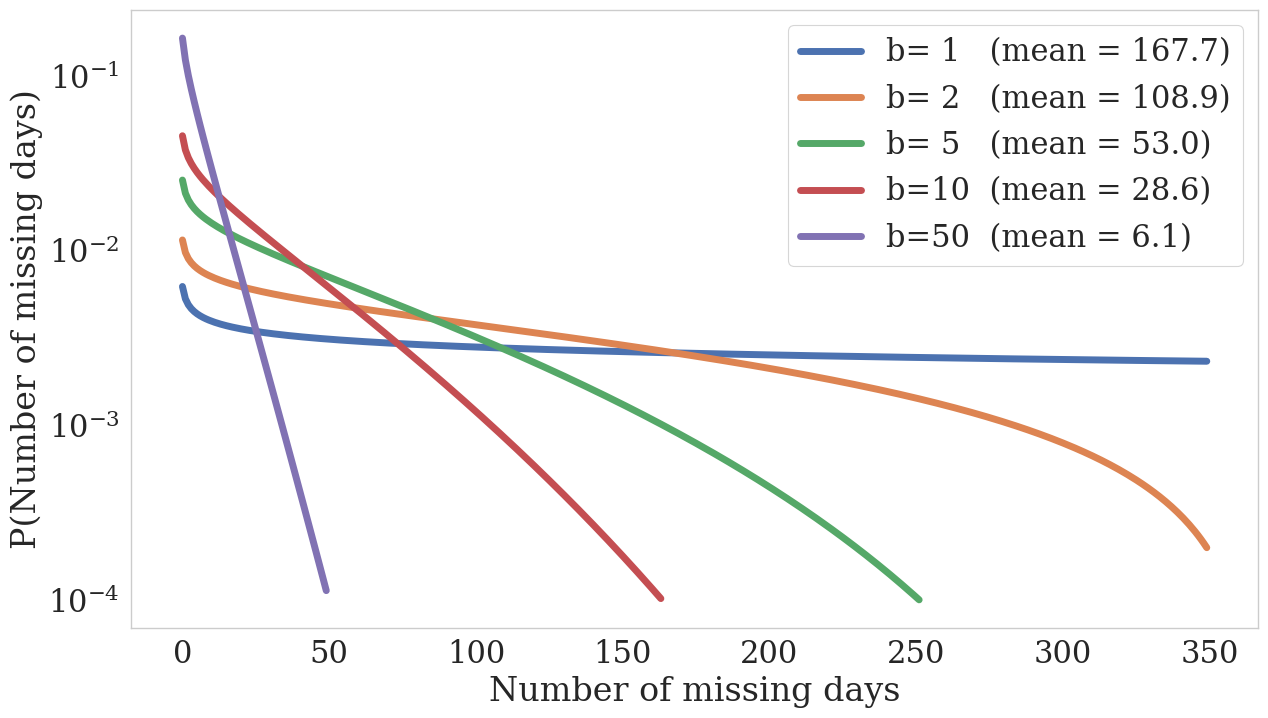

In [14]:
fig, ax = plt.subplots(figsize=(12*1.1, 7*1.1))
#change colormap for matplotlib
n = 365
a = 0.85
x = np.arange(0, 350)
for b in B:
    # samples = np.random.binomial(n=365, p=np.random.beta(a, b, size=size), size=size)
    # sns.histplot(samples, bins=range(0, 365, 1), stat='probability', label='B={}'.format(b), alpha=0.5, )
    mean_value = n * a / (a + b)
    space = ""
    if b<10: space = " "
    label_text = f"b={space}{b:<3} (mean = {mean_value:>2.1f})" 
    pmf = stats.betabinom.pmf(x, n, a, b)
    pmf[pmf < 1e-4] = np.nan
    # ax.plot(x, pmf, label=label_text, lw=5)
    sns.lineplot(x=x, y=pmf, label=label_text, lw=5, ax=ax)
## log scale
plt.yscale('log')
plt.xlabel('Number of missing days')
plt.ylabel('P(Number of missing days)')
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.title('Beta-binomial distribution')
plt.legend()
#increase legend font
# plt.legend(fontsize=17)

plt.grid(False)

plt.tight_layout()


if os.path.exists(save_dir): 
    plt.savefig(os.path.join(save_dir, f'betabinom.png'), bbox_inches='tight', dpi=300)

plt.show()

In [56]:
config_dir = '/home/kbolat/Python/behavio-temporal-vae/runs/sweep_runs_corrected/sweep_Sep13_07-57-26'
config_file = 'config.json'

with open(os.path.join(config_dir, config_file), 'r') as f: config = json.load(f)

In [57]:
config_data = config["data"]

config_data["user_embedding_kwargs"]["fit_kwargs"]["lda"]["doc_topic_prior"] = 1.0/config_data["user_embedding_kwargs"]["model_kwargs"]["num_topics"]
config_data["user_embedding_kwargs"]["fit_kwargs"]["lda"]["topic_word_prior"] = 1.0/config_data["user_embedding_kwargs"]["model_kwargs"]["num_clusters"]

## Import data
dataset_path = os.path.join(config_data["dataset_dir"], config_data["dataset_name"])
df = pd.read_csv(os.path.join(dataset_path, 'dataset.csv'))
data, dates = df.iloc[:,:-2].values, df.date.values
num_days, num_users = df.date.nunique(), df.user.nunique()
print(f'Dataset: {config_data["dataset_name"]}')
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users.')

date_dict = np.load(os.path.join(dataset_path, 'encode_dict.npy'), allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}
if not os.path.exists(os.path.join(dataset_path, 'raw_dates.npy')):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(os.path.join(dataset_path, 'raw_dates.npy'), raw_dates)
else: raw_dates = np.load(os.path.join(dataset_path, 'raw_dates.npy'), allow_pickle=True)

X = downsample_and_pad(np.reshape(data, (num_users, num_days, -1)), config_data["resolution"], config_data["pad"])
X = np.reshape(data, (num_users, num_days, -1))
X, user_mask = remove_unwanted_profiles(X)    
X, raw_dates = subsample_data(X, np.reshape(raw_dates, (num_users, num_days))[user_mask], config_data["subsample_rate"]["user"], config_data["subsample_rate"]["day"])
months = np.array([d.month for d in raw_dates])

num_users, num_days = X.shape[:2]

print("{:.<40}{:.>5}".format("Amputation Parameters", f"a={config_data['ampute_params']['a']}, b={config_data['ampute_params']['b']}"))

X_amputed, missing_idx, _, num_missing_days = ampute_data(X, a=config_data["ampute_params"]["a"], b=config_data["ampute_params"]["b"], random_seed=config_data["random_seed"]) ## X_amputed is a flattened version of X with missing values as NaNs

if config_data["random_seed"] is not None: np.random.seed(config_data["random_seed"])
random_idx = np.random.permutation(np.setdiff1d(np.arange(X_amputed.shape[0]), np.where(missing_idx)[0]))
num_val_data = int(random_idx.shape[0]*config_data["val_ratio"])
num_test_data = int(random_idx.shape[0]*config_data["test_ratio"])
num_train_data = random_idx.shape[0] - num_val_data - num_test_data

print("{:.<40}{:.>5}".format("Number of Training Points", num_train_data))
print("{:.<40}{:.>5}".format("Number of Testing Points", num_test_data))
print("{:.<40}{:.>5}".format("Number of Validation Points", num_val_data))
print("{:.<40}{:.>5}".format("Number of Missing Points", missing_idx.sum()))

val_idx = random_idx[:num_val_data]
test_idx = random_idx[num_val_data:num_val_data+num_test_data]
train_idx = random_idx[num_val_data+num_test_data:]

X_amputed_train = X_amputed.copy()
X_amputed_train[val_idx] = np.nan
X_amputed_train[test_idx] = np.nan

nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_amputed_train)
X_amputed_train = utils.zero_preserved_log_normalize(X_amputed_train, nonzero_mean, nonzero_std, log_output=config_data["scaling"]["log_space"], zero_id=config_data["scaling"]["zero_id"], shift=config_data["scaling"]["shift"])

condition_kwargs, condition_set = conditioning_lib.prepare_conditions(config_data["condition_tag_list"], raw_dates, data=X_amputed.reshape(num_users, num_days, -1), dataset_path=dataset_path, user_embedding_kwargs=config_data["user_embedding_kwargs"], config_dict=config_data)

X_train, user_ids_train, conditions_train = separate_sets(X, condition_set, train_idx)
X_train = utils.zero_preserved_log_normalize(X_train*1.0, nonzero_mean, nonzero_std, log_output=config_data["scaling"]["log_space"], zero_id=config_data["scaling"]["zero_id"], shift=config_data["scaling"]["shift"])
months_train = months[train_idx]

X_val, user_ids_val, conditions_val = separate_sets(X, condition_set, val_idx)
X_val = utils.zero_preserved_log_normalize(X_val*1.0, nonzero_mean, nonzero_std, log_output=config_data["scaling"]["log_space"], zero_id=config_data["scaling"]["zero_id"], shift=config_data["scaling"]["shift"])
months_val = months[val_idx]

X_test, user_ids_test, conditions_test = separate_sets(X, condition_set, test_idx)
X_test = utils.zero_preserved_log_normalize(X_test*1.0, nonzero_mean, nonzero_std, log_output=config_data["scaling"]["log_space"], zero_id=config_data["scaling"]["zero_id"], shift=config_data["scaling"]["shift"])
months_test = months[test_idx]

X_missing, user_ids_missing, conditions_missing = separate_sets(X, condition_set, missing_idx)
months_missing = months[missing_idx]

conditioner = conditioning_lib.Conditioner(**condition_kwargs, condition_set=conditions_train)
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)

user_ids = {"train": user_ids_train, "val": user_ids_val, "test": user_ids_test, "missing": user_ids_missing}
condition_set = {"train": conditions_train, "val": conditions_val, "test": conditions_test, "missing": conditions_missing}
months = {"train": months_train, "val": months_val, "test": months_test, "missing": months_missing}

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=10
Mean of enrolments: 28.59
Number of Training Points...............1377166
Number of Testing Points................459055
Number of Validation Points.............459055
Number of Missing Points................197674
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_1


In [58]:
X_train = trainset.inputs
X_train_denormalized = utils.zero_preserved_log_denormalize(trainset.inputs, nonzero_mean, nonzero_std, log_input=config["data"]["scaling"]["log_space"], zero_id=config["data"]["scaling"]["zero_id"], shift=config["data"]["scaling"]["shift"]).flatten()
X_train_denormalized = X_train_denormalized[X_train_denormalized < 500]

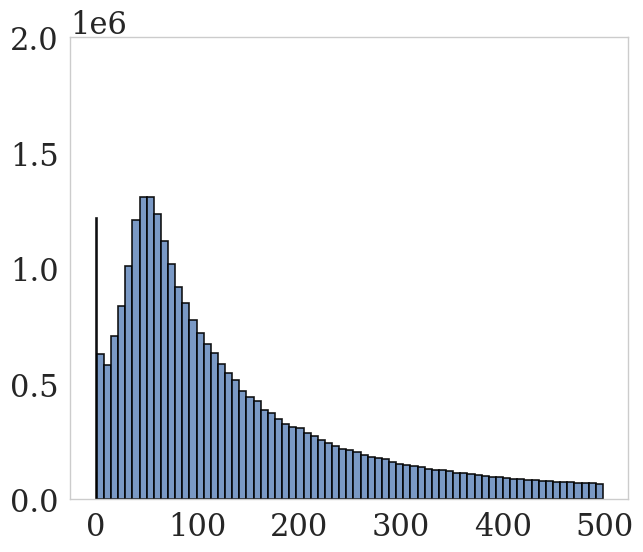

In [59]:
fig, ax = plt.subplots(figsize=(6*1.2, 5*1.2))
ax.hist(X_train_denormalized, bins=np.concatenate((np.array([0,1]), np.arange(1.1,500,7))), alpha=0.9, edgecolor='black', color='#6C8EBF', linewidth=1.2)
ax.set_ylim(0, 2.0e6)
ax.grid(False)
if os.path.exists(save_dir): 
    plt.savefig(os.path.join(save_dir, f'unnormalized_histogram.png'), bbox_inches='tight', dpi=300)
plt.show()

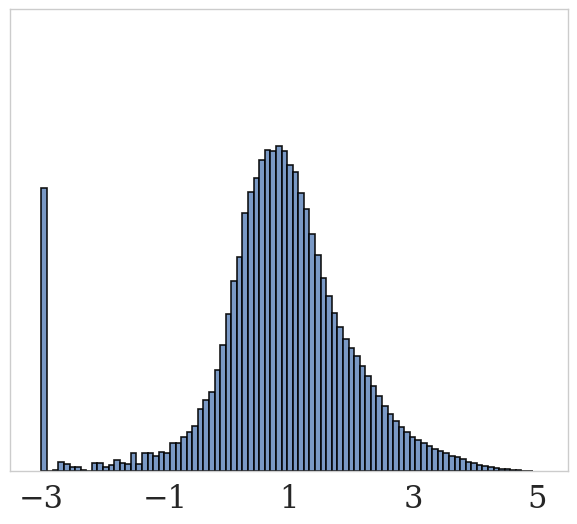

In [60]:
fig, ax = plt.subplots(figsize=(6*1.2, 5*1.2))
ax.hist(X_train.flatten(), bins=np.concatenate((np.array([-3,-2.9]), np.arange(-2.9,5,.09))), alpha=0.9, edgecolor='black', color='#6C8EBF', linewidth=1.2)
ax.set_ylim(0, 2.0e6)
ax.set_yticks([])
ax.set_xticks(np.arange(-3, 5.1, 2))
ax.set_xlim(-3.5, 5.5)

ax.grid(False)

if os.path.exists(save_dir): 
    plt.savefig(os.path.join(save_dir, f'normalized_histogram.png'), bbox_inches='tight', dpi=300)
plt.show()


In [61]:
num_users = len(num_missing_days)

In [62]:
X_all = X.copy()*1.0
X_all_normalized = utils.zero_preserved_log_normalize(X_all, nonzero_mean, nonzero_std, log_output=config_data["scaling"]["log_space"], zero_id=config_data["scaling"]["zero_id"], shift=config_data["scaling"]["shift"])

In [63]:
condition_kwargs_all, condition_set_all = conditioning_lib.prepare_conditions(config_data["condition_tag_list"], raw_dates, data=X_all, dataset_path=dataset_path, user_embedding_kwargs=config_data["user_embedding_kwargs"], config_dict=config_data)

Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_1


In [64]:
X_all_normalized_flt = X_all_normalized.reshape(num_users*num_days, -1)

In [65]:
model = CVAE(input_dim=X_all_normalized_flt.shape[-1], conditioner=conditioner, **config["model"])
model.load(os.path.join(config_dir))

USING SIGMA_LIM!
USING SIGMA_LIM!


In [66]:
conditions_all = torch.tensor(conditioner.transform( {k: v for k, v in condition_set_all.items()})).float()

In [67]:
x_sample = testing_lib.mass_imputation(model, conditions_test=conditions_all, num_mc_samples_prior=10, num_mc_samples_likelihood=1, batch_size=4000, device="cuda:1")

Batch 1/624
Batch 2/624
Batch 3/624
Batch 4/624
Batch 5/624
Batch 6/624
Batch 7/624
Batch 8/624
Batch 9/624
Batch 10/624
Batch 11/624
Batch 12/624
Batch 13/624
Batch 14/624
Batch 15/624
Batch 16/624
Batch 17/624
Batch 18/624
Batch 19/624
Batch 20/624
Batch 21/624
Batch 22/624
Batch 23/624
Batch 24/624
Batch 25/624
Batch 26/624
Batch 27/624
Batch 28/624
Batch 29/624
Batch 30/624
Batch 31/624
Batch 32/624
Batch 33/624
Batch 34/624
Batch 35/624
Batch 36/624
Batch 37/624
Batch 38/624
Batch 39/624
Batch 40/624
Batch 41/624
Batch 42/624
Batch 43/624
Batch 44/624
Batch 45/624
Batch 46/624
Batch 47/624
Batch 48/624
Batch 49/624
Batch 50/624
Batch 51/624
Batch 52/624
Batch 53/624
Batch 54/624
Batch 55/624
Batch 56/624
Batch 57/624
Batch 58/624
Batch 59/624
Batch 60/624
Batch 61/624
Batch 62/624
Batch 63/624
Batch 64/624
Batch 65/624
Batch 66/624
Batch 67/624
Batch 68/624
Batch 69/624
Batch 70/624
Batch 71/624
Batch 72/624
Batch 73/624
Batch 74/624
Batch 75/624
Batch 76/624
Batch 77/624
Batch 78

In [68]:
X_aggregate = X.sum(axis=0).reshape(-1)

In [92]:
x_sample_mu = x_sample["params"]["mu"].detach().cpu()
x_sample_sigma = x_sample["params"]["sigma"].detach().cpu()
x_sample_sample = x_sample["samples"].detach().cpu()

x_sample_mu = x_sample_mu.reshape(x_sample_mu.shape[0], num_users, num_days, -1).sum(axis=1)
x_sample_sample = x_sample_sample[0].reshape(x_sample_sample.shape[1], num_users, num_days, -1)
x_sample_sigma = x_sample_sigma.reshape(x_sample_sigma.shape[0], num_users, num_days, -1)

In [95]:
X_sample_mu = utils.zero_preserved_log_denormalize(x_sample_mu, nonzero_mean, nonzero_std, log_input=config["data"]["scaling"]["log_space"], zero_id=config["data"]["scaling"]["zero_id"], shift=config["data"]["scaling"]["shift"])
X_sample_sample = utils.zero_preserved_log_denormalize(x_sample_sample, nonzero_mean, nonzero_std, log_input=config["data"]["scaling"]["log_space"], zero_id=config["data"]["scaling"]["zero_id"], shift=config["data"]["scaling"]["shift"])


In [94]:
X_sample_mu_agg = X_sample_mu.sum(axis=1).reshape(x_sample_mu.shape[0], -1)
X_sample_sample_agg = X_sample_sample.sum(axis=1).reshape(x_sample_sample.shape[0], -1)

In [ ]:
x_sample_marginal_sigmas = model.decoder.get_marginal_sigmas({"mu": x_sample_mu, "sigma": x_sample_sigma}).detach()
X_sample_marginal_sigmas_agg = utils.zero_preserved_log_denormalize(x_sample_marginal_sigmas.reshape(x_sample_sigma.shape[0], num_users*num_days,-1), nonzero_mean, nonzero_std, log_input=config["data"]["scaling"]["log_space"], zero_id=config["data"]["scaling"]["zero_id"], shift=config["data"]["scaling"]["shift"]).reshape(x_sample_sigma.shape[0],num_users,num_days,-1).sum(axis=1).reshape(x_sample_sigma.shape[0],-1)

In [ ]:
X_sample_marginal_sigmas_agg = utils.zero_preserved_log_denormalize(x_sample_marginal_sigmas.reshape(x_sample_sigma.shape[0], num_users*num_days,-1), nonzero_mean, nonzero_std, log_input=config["data"]["scaling"]["log_space"], zero_id=config["data"]["scaling"]["zero_id"], shift=config["data"]["scaling"]["shift"]).reshape(x_sample_sigma.shape[0],num_users,num_days,-1).sum(axis=1).reshape(x_sample_sigma.shape[0],-1)

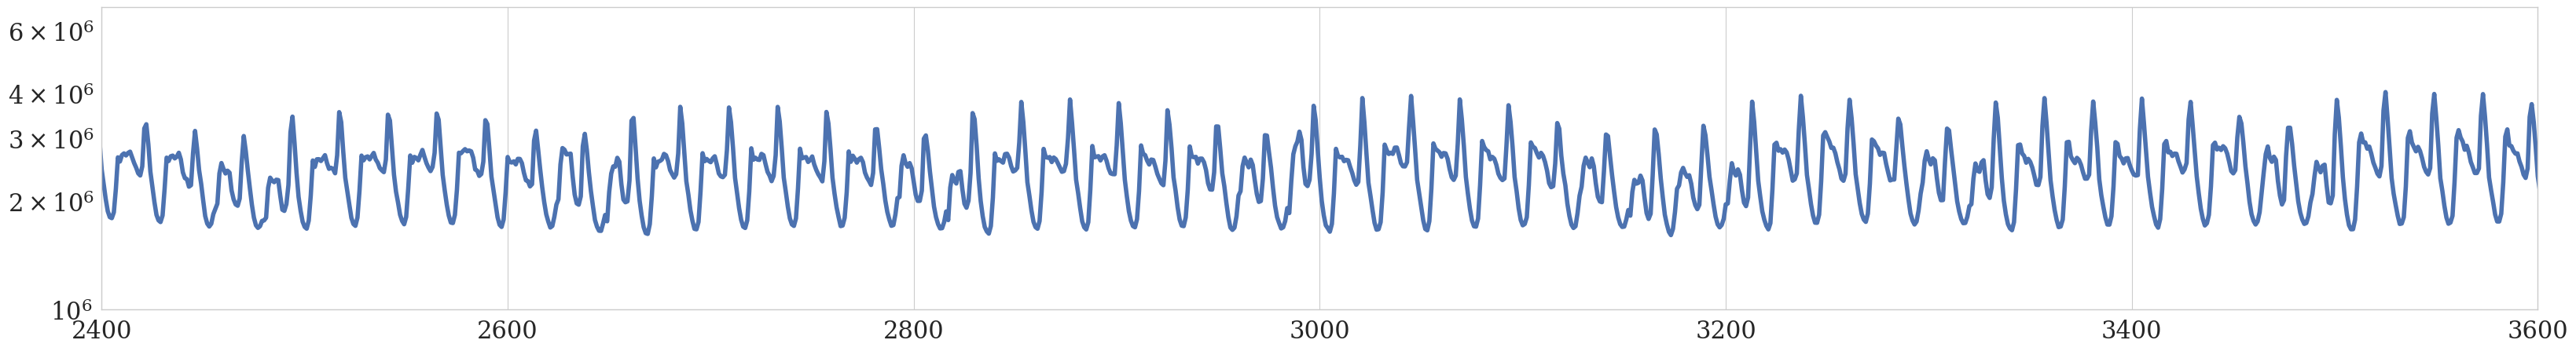

In [96]:
fig, ax = plt.subplots(figsize=(40, 5))

ax.plot(X_aggregate, label='True', lw=4)
# ax.plot(np.median(X_sample_sample_agg, axis=0).T, label="Sample", lw=2)
# ax.plot(X_sample_sample_agg.T, label="Sample", lw=2)
ax.plot(X_sample_mu_agg.T, label='Mean', lw=2, alpha=0.5)

#plot between
# ax.fill_between(np.arange(len(X_aggregate)), X_sample_mu_agg - 2*X_sample_marginal_sigmas_agg, X_sample_mu_agg + 2*X_sample_marginal_sigmas_agg, alpha=0.5, color='gray', lw=2)

plt.xlim(24*100, 24*150)
plt.ylim(1e6,7e6)
plt.yscale('log')

# plt.legend()

plt.show()

In [84]:
np.abs(np.mean(X_sample_sample_agg, axis=0) - X_aggregate).mean()

179557.5197235014

In [85]:
np.sqrt(((np.mean(X_sample_sample_agg, axis=0) - X_aggregate)**2).mean())

296473.5348133612